# KNN

In [3]:
import os, cv2, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import random
import kagglehub

***Dataset Loading and Preprocessing***

In [10]:
dataset_path = "E:/Codes/CVPR/animals"
categories = ['cats', 'dogs', 'panda']
img_size = 32
data, labels = [], []


# Load and preprocess images
for label, category in enumerate(categories):
    folder = os.path.join(dataset_path, category)

    if not os.path.exists(folder):
        print(f"---Folder not found: {folder}---")
        continue

    for file in tqdm(os.listdir(folder), desc=f"Loading {category}"):
        path = os.path.join(folder, file)


        try:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size)).flatten()
                data.append(img)
                labels.append(label)
        except Exception as e:
            print(f"---Could not process file: {file} — {e}---")

# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Show final results
print("---Data loading complete.---")
print(f"Total images loaded: {len(data)}")
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")

Loading panda: 100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 622.66it/s]

---Data loading complete.---
Total images loaded: 3000
Data shape: (3000, 1024)
Labels shape: (3000,)


***Visualization***

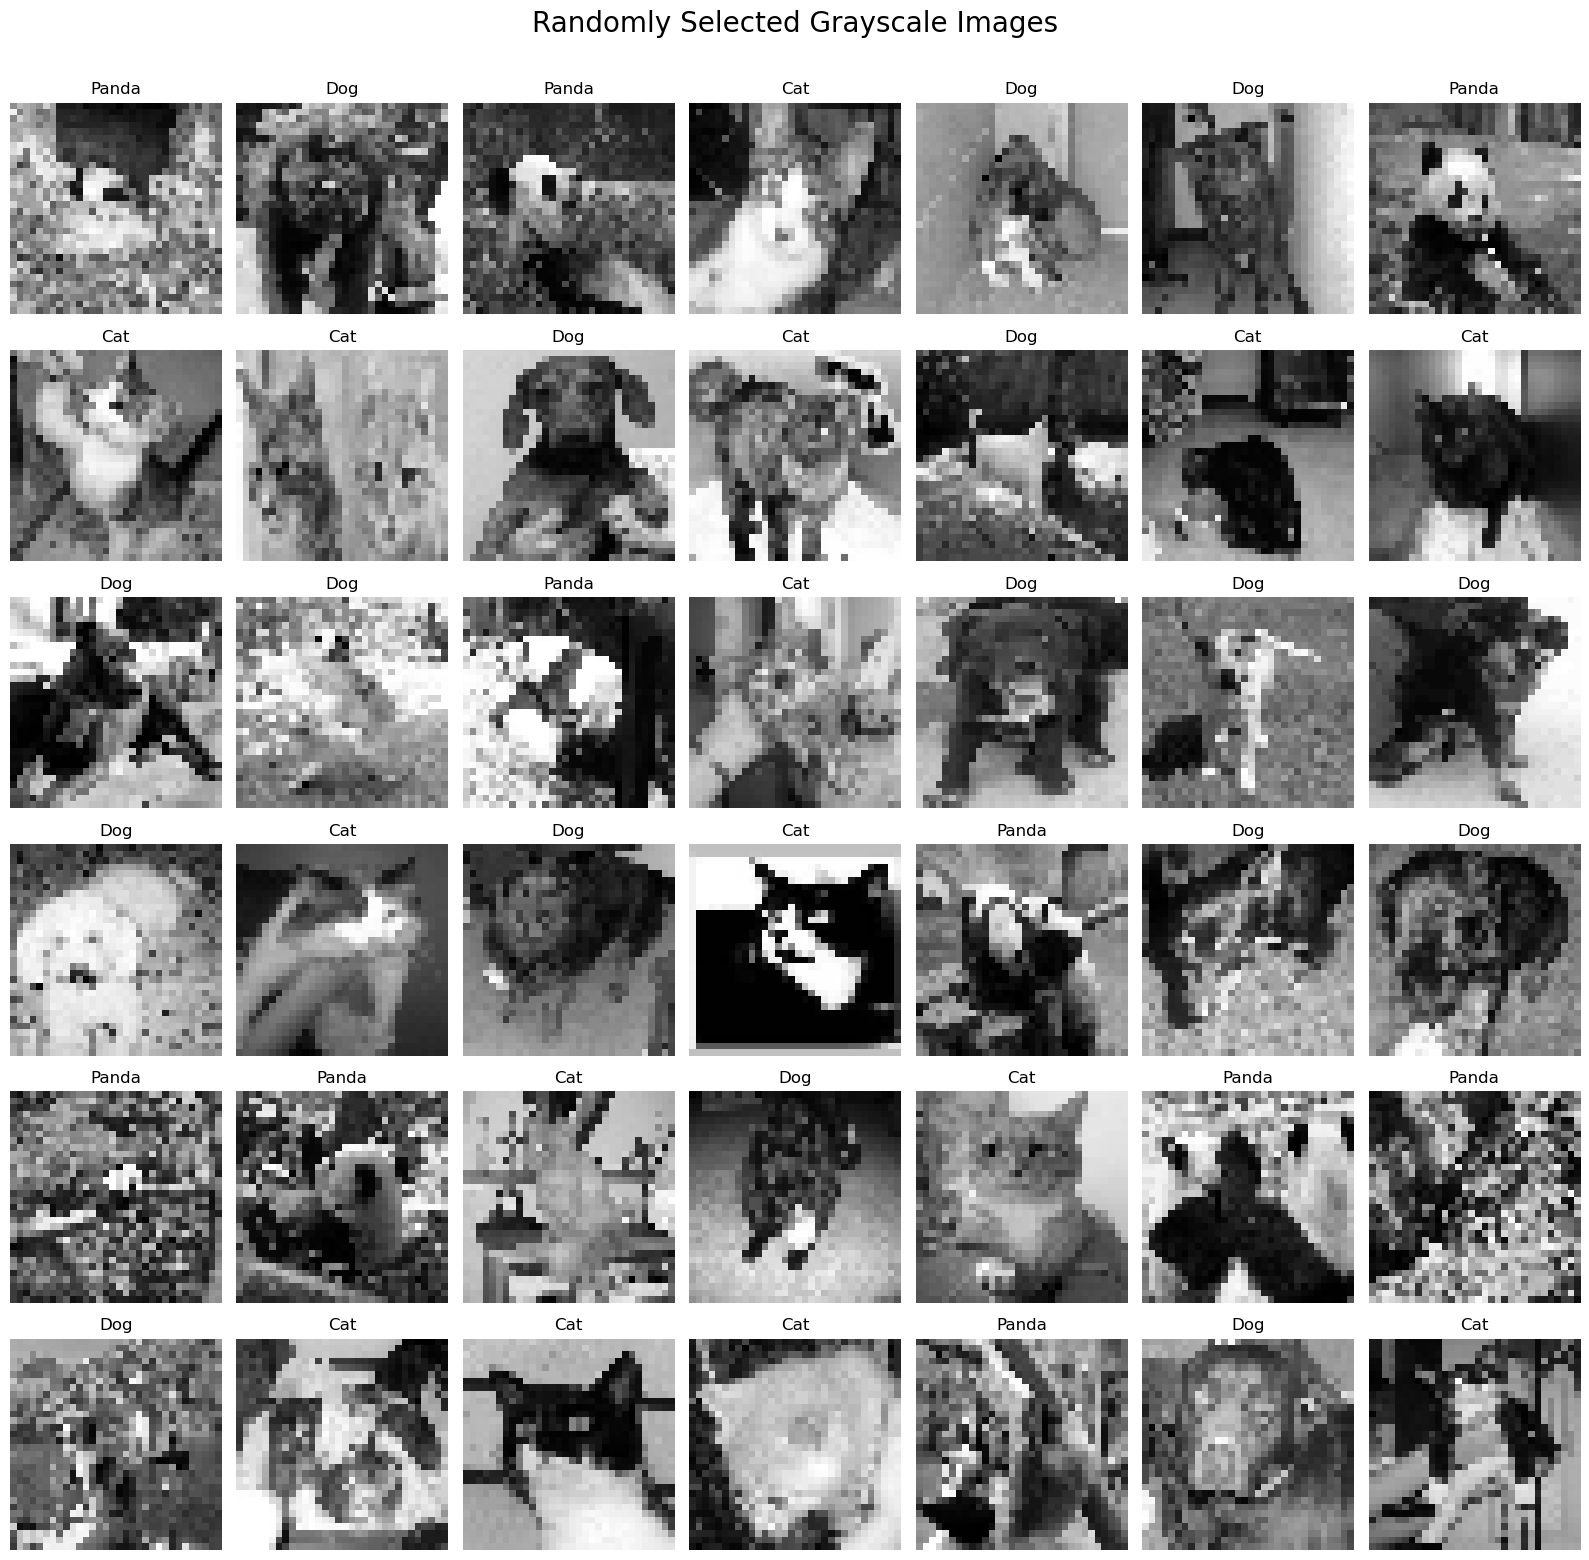

In [14]:
combined = list(zip(data, labels))
sampled = random.sample(combined, 42)
sampled_data, sampled_labels = zip(*sampled)

sampled_data = np.array(sampled_data).reshape(-1, 32, 32)

label_names = ['Cat', 'Dog', 'Panda']
fig, axes = plt.subplots(6, 7, figsize=(16, 16))
fig.suptitle("Randomly Selected Grayscale Images", fontsize=20)

for img_array, label, ax in zip(sampled_data, sampled_labels, axes.flat):
    ax.imshow(img_array, cmap="gray")
    ax.set_title(label_names[label], fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


***Model Evaluation using 5-Fold Cross-Validation***

In [17]:
def evaluate_knn(X, y, distance_metric):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    k_values = list(range(1, 11))
    avg_accuracies = []

    for k in k_values:
        fold_accuracies = []
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            knn = KNeighborsClassifier(n_neighbors=k, metric=distance_metric)
            knn.fit(X_train, y_train)
            preds = knn.predict(X_val)
            fold_accuracies.append(accuracy_score(y_val, preds))
        avg_accuracies.append(np.mean(fold_accuracies))
    
    return k_values, avg_accuracies


***Compare L1 vs L2 Distance Accuracy***

---Accuracy Scores (5-Fold Average):

K   | Manhattan (L1)    | Euclidean (L2)   
---------------------------------------------
1   | 0.4550            | 0.4037           
2   | 0.4063            | 0.3730           
3   | 0.4527            | 0.3943           
4   | 0.4467            | 0.3857           
5   | 0.4450            | 0.3833           
6   | 0.4490            | 0.3920           
7   | 0.4480            | 0.3970           
8   | 0.4527            | 0.3880           
9   | 0.4650            | 0.3963           
10  | 0.4580            | 0.3993           


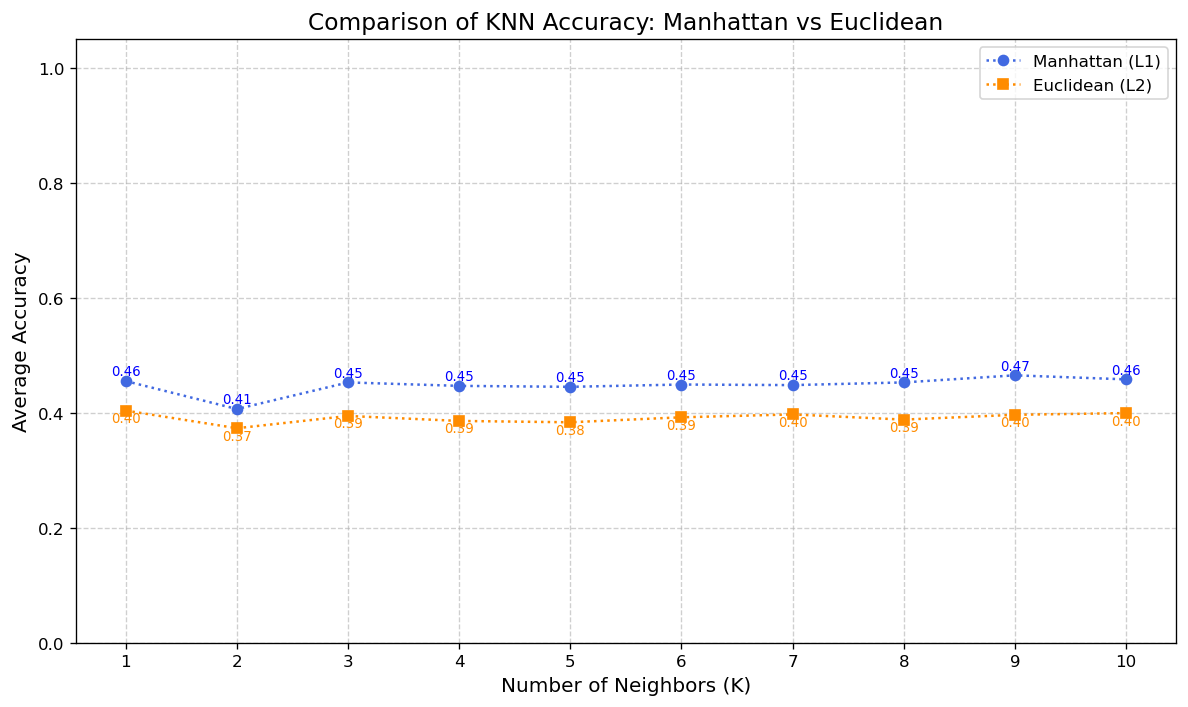

In [20]:
k_l1, acc_l1 = evaluate_knn(data, labels, 'manhattan')
k_l2, acc_l2 = evaluate_knn(data, labels, 'euclidean')

print("---Accuracy Scores (5-Fold Average):\n")
print(f"{'K':<3} | {'Manhattan (L1)':<17} | {'Euclidean (L2)':<17}")
print("-" * 45)
for k, a1, a2 in zip(k_l1, acc_l1, acc_l2):
    print(f"{k:<3} | {a1:<17.4f} | {a2:<17.4f}")

# Plot
plt.figure(figsize=(10, 6), dpi=120)
plt.plot(k_l1, acc_l1, marker='o', linestyle=':', color='royalblue', label='Manhattan (L1)')
plt.plot(k_l2, acc_l2, marker='s', linestyle=':', color='darkorange', label='Euclidean (L2)')

# Annotate accuracy values (offset to avoid overlap)
for k, a1, a2 in zip(k_l1, acc_l1, acc_l2):
    plt.text(k, a1 + 0.01, f"{a1:.2f}", ha='center', fontsize=8, color='blue')
    plt.text(k, a2 - 0.02, f"{a2:.2f}", ha='center', fontsize=8, color='darkorange')

# Plot formatting
plt.title("Comparison of KNN Accuracy: Manhattan vs Euclidean", fontsize=14)
plt.xlabel("Number of Neighbors (K)", fontsize=12)
plt.ylabel("Average Accuracy", fontsize=12)
plt.xticks(k_l1)
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

***Top 5 Predictions by the Final Model***

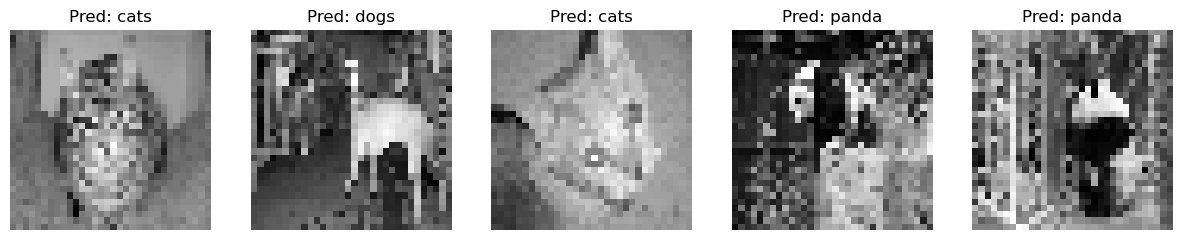

In [28]:
best_k = k_l2[np.argmax(acc_l2)]
final_knn = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')
final_knn.fit(data, labels)

indices = np.random.choice(len(data), 5, replace=False)
sample_imgs = data[indices]
sample_labels = labels[indices]
predictions = final_knn.predict(sample_imgs)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_imgs[i].reshape(32, 32), cmap='gray')
    plt.title(f"Pred: {categories[predictions[i]]}")
    plt.axis('off')
plt.show()

### Discussion

This assignment applied the k-Nearest Neighbors (k-NN) algorithm for grayscale image classification using a subset of the CIFAR-10 dataset with cats, dogs, and pandas. A comparison was made between the Manhattan (L1) and Euclidean (L2) distance metrics using 5-fold cross-validation. Results indicated that Manhattan distance generally provided better classification accuracy due to its ability to capture spatial relationships more effectively. 

The effect of varying k was also examined, revealing that smaller values may lead to overfitting, while larger ones may cause underfitting, making the choice of an optimal k crucial. However, the model’s performance was limited by the use of raw pixel values, with no feature extraction or data augmentation applied.

Future improvements could involve applying Principal Component Analysis (PCA) for dimensionality reduction, using Convolutional Neural Networks (CNNs) for automatic feature learning, and augmenting data with techniques like rotation or flipping to improve generalization. Overall, the project provides a baseline for further experimentation and refinement in image classification.
